In [2]:
import fiona
import rasterio as rs
import rasterio.mask
import numpy as np
import pandas as pd
from rasterio.plot import show

In [3]:
#FILE_PREFIX = "~/data.mint.isi.edu/EarthStat/HarvestedAreaYield175Crops_Geotiff/GeoTiff"
TIFFILES = {
    "springlentil": "EarthStat/area/lentil_HarvestedAreaHectares.tif",
    "maize": "EarthStat/area/maize_HarvestedAreaHectares.tif",
    "sorghum": "EarthStat/area/sorghum_HarvestedAreaHectares.tif",
    "potato": "EarthStat/area/potato_HarvestedAreaHectares.tif",
    "cassava": "EarthStat/area/cassava_HarvestedAreaHectares.tif",
    "millet": "EarthStat/area/millet_HarvestedAreaHectares.tif"
}

In [4]:
df = pd.DataFrame(columns=[
    'country', 'admin1', 'admin2', 'admin3',
    'maize_fractional_area', 'sorghum_fractional_area',
    'potato_fractional_area', 'cassava_fractional_area',
    'millet_fractional_area', "springlentil_fractional_area"
])
# Open multiple shape files
shpfiles = ["gadm36_KEN_3.shp", 
         "gadm36_SDN_3.shp", 
         "gadm36_SSD_3.shp", 
         "gadm36_ETH_3.shp",          
         "gadm36_UGA_3.shp",
         "gadm36_SOM_2.shp",
         "gadm36_DJI_2.shp",         
         "gadm36_ERI_2.shp"]

for shpfile in shpfiles:
    print(shpfile)
    with fiona.open("GADM/"+shpfile, "r") as shapefile:
        for feature in shapefile:
            shape = feature["geometry"]
            props = feature["properties"]
            names = ['','','','']
            for i in range(0,4):
                key = "NAME_" + str(i)
                if key in props:
                    names[i]=props[key]
                    
            row = {
                "country": names[0],
                "admin1": names[1],
                "admin2": names[2],
                "admin3": names[3]
            }

            for crop_name in TIFFILES:
                file = TIFFILES[crop_name]
                key = f"{crop_name}_area"
                with rasterio.open(file) as src:
                    out_image, out_transform = rasterio.mask.mask(src, [shape], crop=True)
                    out_meta = src.meta
                    out_meta.update({"driver": "GTiff",
                         "height": out_image.shape[1],
                         "width": out_image.shape[2],
                         "transform": out_transform})
                    shp = out_image.shape
                    data = out_image.reshape(shp[0]*shp[1]*shp[2])
                    row[key] = np.mean(data)

            df = df.append(row, ignore_index = True)

df.set_index(['country', 'admin1', 'admin2', 'admin3'], inplace=True)
df.to_csv("HOACroplandArea.csv")

gadm36_KEN_3.shp
gadm36_SDN_3.shp
gadm36_SSD_3.shp
gadm36_ETH_3.shp
gadm36_UGA_3.shp
gadm36_SOM_2.shp
gadm36_DJI_2.shp
gadm36_ERI_2.shp


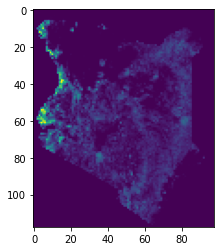

In [108]:
# Experiment
with fiona.open("GADM/gadm36_KEN_0.shp", "r") as shapefile:
    for feature in shapefile:
        shape = feature["geometry"]
        props = feature["properties"]
        for crop_name in TIFFILES:
            if crop_name != "maize":
                continue
            file = TIFFILES[crop_name]
            with rasterio.open(file) as src:
                out_image, out_transform = rasterio.mask.mask(src, [shape], crop=True)
                out_meta = src.meta
                out_meta.update({"driver": "GTiff",
                     "height": out_image.shape[1],
                     "width": out_image.shape[2],
                     "transform": out_transform})
                show(out_image)
                shp = out_image.shape
                with rasterio.open(f"{file}.kenya.tif", "w", **out_meta) as dest:
                    dest.write(out_image)